In [9]:
import random
import numpy as np
import pandas as pd
import os
import mne
import pathlib

from os.path import join as opj
from mne_bids import BIDSPath
from pyprep import NoisyChannels
from mne.preprocessing import ICA
from autoreject import AutoReject


Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


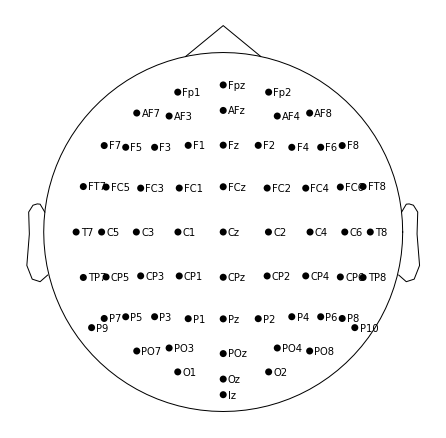

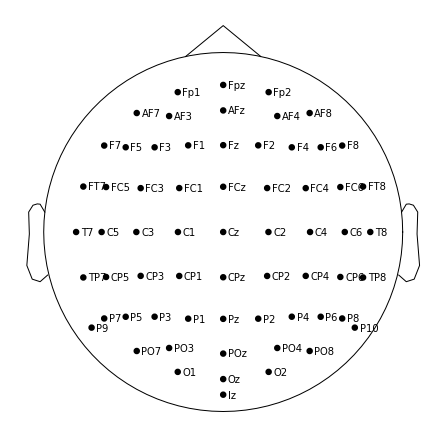

In [22]:
montage = mne.channels.make_standard_montage("biosemi64")

mne.viz.plot_montage(montage)

In [19]:
project_seed = 999 # RNG seed
random.seed(project_seed) # set seed to ensure computational reproducibility

# directories
raw_path = '../eeg_BIDS/' # directory with raw data
preproc_path = '../Preprocessed/' # directory with preprocessed files
events_path = '../events/' # directory with event files

datatype = 'eeg' # data type

# define electrode montage
montage = mne.channels.make_standard_montage("biosemi64")
# montage.plot() # visualize montage

# filter cutoffs
cutoff_low = 1 # adapated to TFR analysis
cutoff_high = 40

# number of components for ICA decomposition
ICA_n_comps = 20

# ICA parameters
ica = ICA(
    n_components = ICA_n_comps,
    noise_cov = None, # channels are scaled to unit variance (“z-standardized”) prior to whitening by PCA
    # 'picard': algorithm that converges faster than 'fastica' and 'infomax' 
    # and is more robust when sources are not completely independent (typical for EEG signal)
    method = 'picard',
    fit_params = None, # use defaults of selected ICA method              
    max_iter = 'auto',  # max number of iterations
    random_state = project_seed # RNG seed
    )

# triggers (from TriggerTable.csv)
trigs = pd.read_csv(opj(events_path, 'TriggerTable.csv'))
#     'manmade/new/hit/forgotten': 1010,
#     'manmade/new/hit/remembered': 1011,
#     'manmade/new/hit/na': 1019,
#     'manmade/new/miss/forgotten': 1020,
#     'manmade/new/miss/remembered': 1021,
#     'manmade/new/miss/na': 1029,
#     'manmade/new/fa/forgotten': 1030,
#     'manmade/new/fa/remembered': 1031,
#     'manmade/new/fa/na': 1039,             
#     'manmade/new/cr/forgotten': 1040,
#     'manmade/new/cr/remembered': 1041,
#     'manmade/new/cr/na': 1049,
#     'manmade/new/na/forgotten': 1090,
#     'manmade/new/na/remembered': 1091,
#     'manmade/new/na/na': 1099,
#     'manmade/old/hit/forgotten': 1110,
#     'manmade/old/hit/remembered': 1111,
#     'manmade/old/hit/na': 1119,
#     'manmade/old/miss/forgotten': 1120,
#     'manmade/old/miss/remembered': 1121,
#     'manmade/old/miss/na': 1129,
#     'manmade/old/na/forgotten': 1190,
#     'manmade/old/na/remembered': 1191,
#     'manmade/old/na/na': 1199,
#     'natural/new/hit/forgotten': 2010,
#     'natural/new/hit/remembered': 2011,
#     'natural/new/hit/na': 2019,
#     'natural/new/miss/forgotten': 2020,
#     'natural/new/miss/remembered': 2021,
#     'natural/new/miss/na': 2029,
#     'natural/new/fa/forgotten': 2030,
#     'natural/new/fa/remembered': 2031,
#     'natural/new/fa/na': 2039,
#     'natural/new/cr/forgotten': 2040,
#     'natural/new/cr/remembered': 2041,
#     'natural/new/cr/na': 2049,
#     'natural/new/na/forgotten': 2090,
#     'natural/new/na/remembered': 2091,
#     'natural/new/na/na': 2099,
#     'natural/old/hit/forgotten': 2110,
#     'natural/old/hit/remembered': 2111,
#     'natural/old/hit/na': 2119,
#     'natural/old/miss/forgotten': 2120,
#     'natural/old/miss/remembered': 2121,
#     'natural/old/miss/na': 2129,
#     'natural/old/na/forgotten': 2190,
#     'natural/old/na/remembered': 2191,
#     'natural/old/na/na': 2199

# combined triggers according to research questions
# Q1
# 'manmade' condition
# NOTE: 'manmade' excludes NAs in behavior: 
# although scene category is independent from response, 
# NAs may reflect drops in attention and, consequently, incomplete stimulus perception
trigs_Q1_manmade = trigs[(trigs['scene_category'] == 'man-made') 
                         & (trigs['behavior'] != 'na')
                         ]['trigger']
# 'natural' condition
# NOTE: 'natural' excludes NAs in behavior: 
# although scene category is independent from response, 
# NAs may reflect drops in attention and, consequently, incomplete stimulus perception
trigs_Q1_natural = trigs[(trigs['scene_category'] == 'natural') 
                         & (trigs['behavior'] != 'na')
                         ]['trigger']
# Q2
# 'new' condition
# NOTE: 'new' excludes NAs in behavior (possible drops in attention)
trigs_Q2_new = trigs[(trigs['old'] == 'new') 
                         & (trigs['behavior'] != 'na')
                         ]['trigger']
# 'old' condition
# NOTE: 'old' excludes NAs in behavior (possible drops in attention)
trigs_Q2_old = trigs[(trigs['old'] == 'old') 
                         & (trigs['behavior'] != 'na')
                         ]['trigger']
# Q3
# 'old-hit'
# NOTE: 'old-hit' must only include 
# old in presentation and hit in behavior but can include NAs in memory: 
# the point is whether the image has been initially successfully categorized as old, 
# regardless of whether it's recognized as such in subsequent presentations
trigs_Q3_old_hit = trigs[(trigs['old'] == 'old') 
                         & (trigs['behavior'] == 'hit')
                         ]['trigger']
# 'old-miss'
# NOTE: 'old-miss' must only include 
# old in presentation and misses in behavior but can include NAs in memory: 
# the point is whether the image has been initially unsuccessfully categorized as old, 
# regardless of whether it's recognized as such in subsequent presentations
trigs_Q3_old_miss = trigs[(trigs['old'] == 'old') 
                         & (trigs['behavior'] == 'miss/forgotten')
                         ]['trigger']
# Q4
# 'remembered'
# NOTE: 'remembered' can be both 'new' and 'old' and include all behavior
trigs_Q4_remembered = trigs[trigs['subsequent_correct'] == 'subsequent_remembered'
                            ]['trigger']
# 'forgotten' 
# NOTE: 'forgotten' can be both 'new' and 'old' and include all behavior
trigs_Q4_forgotten = trigs[trigs['subsequent_correct'] == 'subsequent_forgotten'
                         ]['trigger']

# epoch length (relative to stimulus)
begin_epoch = -0.3 # I need to change this to 0.3 seconds (was 0.2s before) otherwise the Morlet wavelet transformation wont run
end_epoch = 0.5

# AutoReject parameters
ar = AutoReject(
    n_interpolate = None, # (default) values to try for the number of channels for which to interpolate (default: np.array([1, 4, 32]))
    consensus = None, # (default) values to try for percentage of channels that must agree as a fraction of the total number of channels (default: np.linspace(0, 1.0, 11))
    cv = 10, # cross-validation object
    picks = datatype,
    thresh_method = 'bayesian_optimization',
    random_state = project_seed # RNG seed
    )

In [ ]:
# get all participant names
subs = [name for name in os.listdir(raw_path) if name.startswith('sub')] 

for ssj in subs:
    
    # create subdirectory
    pathlib.Path(opj(preproc_path + ssj)).mkdir(exist_ok = True) 
    
    # message in console
    print("--------------------")
    print("--- load " + ssj + " ---")
    print("--------------------")
    
    # create BIDS path
    bids_path = BIDSPath(
        subject = ssj[-3:], # subject identifier (remove 'sub-' because '-' is not allowed as character)
        session = None, # acquisition session: not specified
        task = 'xxxx', # task name
        acquisition = None, # acquisition parameters: not specified
        run = None, # run number: not specified
        processing = None, # processing label: not specified
        recording = None, # recording name: not specified
        space = None, # coordinate space (for anatomical and sensor location): not specified
        split = None, # split of continuous recording file: not specified
        suffix = datatype, # filename suffix
        extension = None, # file extension: not specified
        datatype = datatype, # BIDS data type        
        root = raw_path, # directory of BIDS dataset
        check = True # check BIDS conformity
        )
    
    # load data
    raw = mne.io.read_raw_brainvision(
        bids_path, 
        eog = ('VEOG', 'HEOG','IO1','IO2','Afp9','Afp10'), # ocular channels
        misc = ('M1','M2'), # mastoid channels
        preload = True
        )        
    
    # # plot raw data
    # raw.plot(
    #     duration = 20, # time window (in seconds)
    #     start = 20, # start time (in seconds)
    #     n_channels = len(raw.ch_names), # number of channels to plot
    #     color = 'darkblue', # line color
    #     bad_color = 'red', # line color: bad channels
    #     remove_dc = True, # remove DC component (visualization only)
    #     proj = False, # apply projectors prior to plotting
    #     group_by = 'type', # group by channel type
    #     butterfly = False # butterfly mode        
    #     )
    
    # check data info    
    print(raw.info)
    
    # %% ELECTRODE MONTAGE

    # message in console
    print("--------------------------------")
    print("--- assign electrode montage ---")
    print("--------------------------------")
    
    # assign electrode montage
    raw = raw.set_montage(montage)
    
    # %% FILTERING
    
    # message in console
    print("--------------------------------------")
    print("--- high-pass and low-pass filters ---")
    print("--------------------------------------")
    
    # filter data
    raw = raw.filter( # apply high-pass filter
        l_freq = cutoff_low,
        h_freq = None).filter( # apply low-pass filter
            l_freq = None,
            h_freq = cutoff_high
            )

    # # plot filtered data
    # raw.plot(
    #     duration = 20,
    #     start = 20,
    #     n_channels = len(raw.ch_names),
    #     color = 'darkblue',
    #     bad_color = 'red',
    #     remove_dc = True,
    #     proj = False,
    #     group_by = 'type',
    #     butterfly = False     
    #     )

    # %% BAD CHANNEL DETECTION

    # message in console
    print("-----------------------------")
    print("--- detect noisy channels ---")
    print("-----------------------------")

    # detect noisy channels
    nd = NoisyChannels(
        raw,
        # do not apply 1 Hz high-pass filter before bad channel detection:
        # the data have already been high-pass filtered at 0.1 Hz
        # and we don't want to miss bad channels with slow drifts
        do_detrend = False,
        random_state = project_seed # RNG seed
        )
    
    # detect noisy channels based on:
    # - missing signal (NaN)
    # - flat signal
    # - deviation
    # - HF noise (frequency components > 50 Hz considerably higher than median channel noisiness)
    # - correlation
    #   - bad correlation window if maximum correlation with another channel is below the provided correlation threshold (default: 0.4)
    #   - a channel is “bad-by-correlation” if its fraction of bad correlation windows is above the bad fraction threshold (default: 0.01)
    # - low signal-to-noise ratio (too much high-frequency noise + low channel correlation)
    # - dropout (long time windows with completely flat signal, default fraction threshold 0.01)
    # - RANSAC (random sample consensus approach): predict signal based on signals and spatial locations of other currently-good channels
    #   - split recording into non-overlapping time windows (default: 5 seconds)
    #   - correlate each channel’s RANSAC-predicted signal with its actual signal
    #   - bad window if predicted vs. actual signal correlation below correlation threshold (default: 0.75)
    #   - bad channel if its fraction of bad RANSAC windows is above threshold (default: 0.4)
    # for more info, see https://pyprep.readthedocs.io/en/latest/generated/pyprep.NoisyChannels.html#pyprep.NoisyChannels
    nd.find_all_bads(
        ransac = True, 
        channel_wise = False
        )
    
    # extract bad channels
    bads = nd.get_bads(verbose = True)
       
    # add bad channel info to filtered data 
    raw.info['bads'] = bads 
    
    # save bad channels to file
    with open(opj(preproc_path + ssj, ssj + '_bad_channels.txt'), 'w') as f:
        for item in bads:
            f.write("%s\n" % item)
    
    # %% CHANNEL INTERPOLATION
    
    # message in console
    print("----------------------------------")
    print("--- interpolate noisy channels ---")
    print("----------------------------------")
    
    # interpolate bad channels (spherical spline interpolation)    
    raw = raw.interpolate_bads(
        reset_bads = True # remove bad channel list from info
        )        
        
    
    # %% REFERENCING
    
    # message in console
    print("-------------------")
    print("--- referencing ---")
    print("-------------------")
     
    # average reference
    raw = raw.set_eeg_reference(ref_channels = 'average')

    # %% SAVE DATA
    
    # raw.save(opj(preproc_path + ssj, ssj + '_eeg.fif'), overwrite = True)
    
    # %% ARTIFACT CORRECTION: ICA
    # https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html?highlight=ica
    
    # # load data (for debugging only)
    # raw = mne.io.read_raw_fif(
    #     opj(preproc_path + ssj, ssj + '_eeg.fif'),
    #     preload = True
    #     )

    # message in console
    print("------------")
    print("--- ICA ---" )
    print("------------")
    
    # copy data and apply 1 Hz high-pass filter before ICA
    raw_ICA = raw.copy().filter(l_freq = 1, h_freq = None)

    # fit ICA to low-pass filtered data
    ica.fit(raw_ICA)
   
    # find components that match the vertical EOG pattern
    eog_indices_veog, eog_scores_veog = ica.find_bads_eog(raw, 
                                                          ch_name = 'VEOG',
                                                          measure = 'zscore',
                                                          reject_by_annotation = False,
                                                          l_freq = 1,
                                                          h_freq = 10
                                                          )    
    
    # find components that match the horizontal EOG pattern
    eog_indices_heog, eog_scores_heog = ica.find_bads_eog(raw, 
                                                          ch_name = 'HEOG',
                                                          measure = 'zscore',
                                                          reject_by_annotation = False,
                                                          l_freq = 1,
                                                          h_freq = 10 
                                                          )

    # merge vEOG and hEOG components
    union_indices_eog = list(set(eog_indices_veog).union(set(eog_indices_heog)))
    
    # assign artifactual ICA components to exclude from data
    ica.exclude = union_indices_eog

    # apply ICA to unfiltered data
    raw = ica.apply(raw)
        

    # %% SAVE DATA
    
    # raw.save(opj(preproc_path + ssj, ssj + '_eeg.fif'), overwrite = True)
    
    # %% CREATE EPOCHS (ALL CONDITIONS)

    # # load data (for debugging only)
    # raw = mne.io.read_raw_fif(
    #     opj(preproc_path + ssj, ssj + '_eeg.fif'),
    #     preload = True
    #     )

    # message in console
    print("---------------------")
    print("--- create epochs ---")
    print("---------------------")

    # load event file
    events_csv = pd.read_csv(opj(events_path, 'EMP' + ssj[-2:] + '_events.csv'))    
    events = events_csv[['latency','trial','trigger']].to_numpy(dtype = int)

    # # visualize events
    # mne.viz.plot_events(
    #     events,
    #     sfreq = raw.info['sfreq'] # sample frequency (to display data in seconds)
    #     )
    
    # create epochs (all conditions)
    # NOTE: epochs are subsampled (512 Hz --> 128 Hz),
    # to lower the chances of Type II error in subsequent statistical analyses
    epochs = mne.Epochs(
        raw, 
        events, # events
        tmin = begin_epoch, # start epoch
        tmax = end_epoch, #end epoch
        baseline = (begin_epoch, 0), # time window for baseline correction
        picks = None, # include all channels 
        preload = True,
        decim = 4, # subsample data by a factor of 4, i.e., 128 Hz (for more info, see https://mne.tools/stable/overview/faq.html#resampling-and-decimating)
        detrend = None, # do not detrend before baseline correction        
        reject_by_annotation = False # do not reject based on annotations
        )
    
    # # plot epochs
    # epochs.plot(
    #     picks = datatype,
    #     scalings = None,
    #     n_epochs = 5, 
    #     n_channels = 64, 
    #     events = events,
    #     butterfly = False
    #     )

    # %% ARTIFACT REJECTION
    # artifact rejection is run on all conditions simultanously, 
    # to avoid bias due to condition-specific artifacts
      
    # message in console
    print("---------------------------")
    print("--- reject noisy epochs ---")
    print("---------------------------")
    
    # run artifact rejection
    ar.fit(epochs)
    epochs_clean, reject_log = ar.transform(epochs, return_log = True) 
    
    # visualize reject log
    # reject_log.plot('horizontal')
    
    # list rejected epochs
    dropped_epochs = list(np.where(reject_log.bad_epochs)[0])
    
    # save rejected epochs to file
    with open(opj(preproc_path + ssj, ssj + '_droppedEpochs.txt'), 'w') as file:
        for x in dropped_epochs:
            file.write("%i\n" % x)
    
    # %% SAVE DATA
    
    epochs_clean.save(opj(preproc_path + ssj, ssj + '_AutoReject_epo.fif'), overwrite = True)
    
    # %% CREATE EPOCHS
    # create epochs for different research questions
    
    # # load data (for debugging only)
    # epochs_clean = mne.read_epochs(
    #     opj(preproc_path, ssj + '_epochs_AutoReject.fif'),
    #     preload = True
    #     )    
    
    # message in console
    print("----------------------------------------")
    print("--- create condition-specific epochs ---")
    print("----------------------------------------")
    
    # create epochs
    # convert to string each trigger in the list,
    # create epochs, and save them to file
    epochs_manmade = epochs_clean[[str(i) for i in trigs_Q1_manmade]].save(opj(preproc_path + ssj, ssj + '_manmade_epo.fif'), overwrite = True) # 'manmade'
    epochs_natural = epochs_clean[[str(i) for i in trigs_Q1_natural]].save(opj(preproc_path + ssj, ssj + '_natural_epo.fif'), overwrite = True) # 'natural'
    epochs_new = epochs_clean[[str(i) for i in trigs_Q2_new]].save(opj(preproc_path + ssj, ssj + '_new_epo.fif'), overwrite = True) # 'new'
    epochs_old = epochs_clean[[str(i) for i in trigs_Q2_old]].save(opj(preproc_path + ssj, ssj + '_old_epo.fif'), overwrite = True) # 'old'
    epochs_old_hit = epochs_clean[[str(i) for i in trigs_Q3_old_hit]].save(opj(preproc_path + ssj, ssj + '_old_hit_epo.fif'), overwrite = True) # 'old-hit'
    epochs_old_miss = epochs_clean[[str(i) for i in trigs_Q3_old_miss]].save(opj(preproc_path + ssj, ssj + '_old_miss_epo.fif'), overwrite = True) # 'old-miss'
    epochs_remembered = epochs_clean[[str(i) for i in trigs_Q4_remembered]].save(opj(preproc_path + ssj, ssj + '_remembered_epo.fif'), overwrite = True) # 'remembered'
    epochs_forgotten = epochs_clean[[str(i) for i in trigs_Q4_forgotten]].save(opj(preproc_path + ssj, ssj + '_forgotten_epo.fif'), overwrite = True) # 'forgotten'

    # %% END
    
    # delete data from previous participant, to free RAM
    del raw, raw_ICA
    
    # message in console
    print("-----------")
    print("--- END ---")
    print("-----------")
    

--------------------
--- load sub-001 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-001/eeg/sub-001_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 2541055  =      0.000 ...  4962.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filters ---
--------------------------------------
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-002 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-002/eeg/sub-002_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1840127  =      0.000 ...  3593.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filters ---
--------------------------------

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=1


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

Dropped 19 epochs: 5, 6, 21, 23, 36, 60, 75, 85, 93, 94, 121, 139, 250, 316, 327, 643, 712, 1039, 1156
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-003 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-003/eeg/sub-003_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1991679  =      0.000 ...  3889.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filters ---
--------------------------------------
Filtering raw 

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

Dropped 5 epochs: 273, 348, 431, 632, 784
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-004 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-004/eeg/sub-004_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1854463  =      0.000 ...  3621.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filters ---
--------------------------------------
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=1


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

Dropped 2 epochs: 179, 843
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-005 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-005/eeg/sub-005_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1893375  =      0.000 ...  3697.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filters ---
--------------------------------------
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=1


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

Dropped 68 epochs: 5, 26, 35, 42, 44, 69, 89, 103, 176, 212, 257, 261, 273, 286, 294, 306, 308, 313, 322, 324, 384, 398, 404, 428, 450, 451, 480, 489, 493, 523, 563, 576, 599, 603, 615, 619, 642, 646, 691, 754, 763, 777, 810, 819, 822, 829, 831, 834, 837, 843, 865, 876, 892, 910, 925, 931, 942, 948, 965, 969, 973, 983, 1021, 1052, 1063, 1066, 1137, 1150
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-006 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-006/eeg/sub-006_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 2139647  =      0.000 ...  4178.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs:

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Found 4 uniquely bad channels:

0 by NaN: []

1 by flat: ['POz']

0 by deviation: []

0 by HF noise: []

3 by correlation: ['CP5', 'P5', 'PO4']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

----------------------------------
--- interpolate noisy channels ---
----------------------------------
Interpolating bad channels
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors
-------------------
--- referencing ---
-------------------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
------------
--- ICA ---
------------
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Wind

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

Dropped 28 epochs: 65, 138, 346, 394, 428, 461, 478, 492, 517, 556, 589, 610, 614, 656, 667, 782, 822, 827, 840, 850, 877, 886, 972, 1089, 1108, 1122, 1172, 1180
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-008 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-008/eeg/sub-008_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1901055  =      0.000 ...  3712.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filter

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=1


  0%|          | Repairing epochs : 0/1200 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
----------------------------------------
--- create condition-specific epochs ---
----------------------------------------
-----------
--- END ---
-----------
--------------------
--- load sub-010 ---
--------------------
Extracting parameters from ../eeg_BIDS/sub-010/eeg/sub-010_task-xxxx_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 1898495  =      0.000 ...  3707.998 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 6 EOG, 2 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 72
 projs: []
 sfreq: 512.0 Hz
>
--------------------------------
--- assign electrode montage ---
--------------------------------
--------------------------------------
--- high-pass and low-pass filters ---
--------------------------------

  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]